### Import Lib

In [280]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.wkt import loads
import constant as c
from pyproj import CRS
from sklearn.neighbors import NearestNeighbors
import sys;sys.path.append('../')
from util.distance import sphere_distance
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen
import math
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

### Acquire Data

In [3]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]

#### 1. Get Boundary

In [4]:
# Setting COLS
SIM_CAL_COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'bs_ebit', # X3
    'bs_gas', # X4
    'bs_elct', # X5
    'bd_platarea', # X6
    'bd_archarea', # X7
    'bd_totarea', # X8
    'bd_totflrcnt', # X9
    'bd_elvtent', # X10
    'bd_height', # X11
    'bd_vintage', # X12
    'bd_ilp' # X13
    ]

- Data preparation(calculating nearest grid_idx, and apply Standard Scaler)

In [232]:
# Function to find grid indexes within a radius of 300 meters
def find_neighbors_within_radius(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances <= 400, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors

def find_queen_neighbors(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances < 100*math.sqrt(2)+1, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors


def compare_mean(row1, rows, sim_cal_cols):
    """
    square the difference and sum for all columns and divide by 13 and make that root. 
    input is one row data and multiple rows data and sim_cal_cols. 
    :params row1: one row
    :params rows: multiple rows
    """
    row1_mean = np.mean(row1[sim_cal_cols])
    rows_mean = np.mean(rows[sim_cal_cols], axis=0)
    diff_squared = np.sum((row1_mean - rows_mean)**2)
    mean_diff = np.sqrt(diff_squared / len(sim_cal_cols))
    return mean_diff

In [348]:
# calculate the extent to which grids in CBD boundary are similar to each other
gdf = gpd.GeoDataFrame(gdf_2022_ybd, geometry='geometry_grids')
# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf = gdf.dropna() # drop any data have null value

# and normailze
# Initialize the StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the data
scaler.fit(gdf[SIM_CAL_COLS])
# Transform the data using the scaler
normalized_data = scaler.transform(gdf[SIM_CAL_COLS])
gdf_normalized = gdf.copy()
gdf_normalized[SIM_CAL_COLS] = normalized_data


In [349]:
centroid_gdf_idx = gdf_normalized['bd_height'].idxmax()
print(f'Centroid Building is {gdf_normalized.loc[centroid_gdf_idx].bdnm}\ngrid_idx is {gdf_normalized.loc[centroid_gdf_idx].grid_idx}')
centroid_grid_idx = [gdf_normalized.loc[centroid_gdf_idx].grid_idx][0]
# declare init_cluster
init_cluster = [centroid_grid_idx] +\
                find_queen_neighbors(gdf_normalized, centroid_grid_idx) +\
                find_neighbors_within_radius(gdf_normalized, centroid_grid_idx)
init_cluster = list(set(init_cluster))
# init_cluster.append(36735)

Centroid Building is 파크원
grid_idx is 12556


In [350]:
# 0606 ver2
prev_pass_idxs = init_cluster
cluster = init_cluster

print(f'!! INIT CLUSTER: {init_cluster}')
n_init_cluster = len(init_cluster)
data = {'grid_idx': init_cluster, 'diffs': [0]*n_init_cluster, 'phase': [0]*n_init_cluster}
phase_results = pd.DataFrame(data)

# experiment settings
TOPK = 3 # number of grids selected for each clustering phase
PHASE_N = 50

for phase in range(PHASE_N):
    # 1) GET TBA INDEXS IN THIS PHASE
    if phase > 0:
        this_tba_idxs = prev_fail_idxs # tba idx for this phase contained failed idx in the prev phase
    else:
        this_tba_idxs = [] # for the first phase, there is no prev fail idx so that we declare null list
    
    for prev_pass_idx in prev_pass_idxs:
        tba_idx = find_queen_neighbors(gdf_normalized, prev_pass_idx)
        this_tba_idxs = this_tba_idxs + tba_idx
    # print(this_tba_idxs)

    if not len(this_tba_idxs) > 0: break
    this_tba_idxs = list(set(this_tba_idxs)- set(cluster))
    # print(f'!! {len(this_tba_idxs)} TBA indexs in\n{phase+1}th Phase')
    # print(f'!! {cluster} were in cluster in prev phase')
    
    # 2) CALCULATE FEATURE DISTANCE
    idxs = []
    diffs = []
    
    for tba_idx in this_tba_idxs:
        copied_cluster = cluster[:]
        cluster_gdf    = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
        tba_gdf        = gdf_normalized[gdf_normalized['grid_idx'] == tba_idx]
        mean_diff      = compare_mean(tba_gdf, cluster_gdf, SIM_CAL_COLS)
        idxs.append(tba_idx); diffs.append(mean_diff)

    # 3) GET 3 GRID_IDX which is near to CLUSTER
    data = {'grid_idx': idxs, 'diffs': diffs}
    result_df = pd.DataFrame(data)
    selected_df = result_df.nsmallest(TOPK, 'diffs')
    selected_df['phase'] = [phase + 1] * len(selected_df)

    # 4) AND MAKE PHASE RESULTS AND NEW CLUSTER
    phase_results = pd.concat([phase_results, selected_df], axis = 0)
    this_pass_idxs =  list(selected_df['grid_idx'])
    this_fail_idxs = [x for x in this_tba_idxs if x not in this_pass_idxs]
    cluster = cluster + this_pass_idxs

    # 5) CHANGE VARIABLE NAME FOR NEXT PHASE
    prev_pass_idxs = this_pass_idxs
    prev_fail_idxs = this_fail_idxs
# phase_results

!! INIT CLUSTER: [12481, 12556, 12528, 12503, 12509]


In [366]:
def within_boundary_distance(gdf, sim_cal_cols) -> float:
    pairwise_distances = []
    for row1, row2 in combinations(gdf.iterrows(), 2):
        distance = sum(abs(row1[1][col] - row2[1][col]) for col in SIM_CAL_COLS)
        pairwise_distances.append(distance)
    # average_distance = sum(pairwise_distances) / len(pairwise_distances)
    average_distance = sum(pairwise_distances) / len(pairwise_distances)
    # boundary_similarity = math.exp(-(average_distance/100))
    
    # penalty = 1 / math.sqrt(len(pairwise_distances))
    return average_distance 

def within_boundary_similarity(dist, n_cluster) -> float:
    return math.exp(-dist/(n_cluster**2))

In [367]:
phase_results

,grid_idx,diffs,phase
0,12481.0,0.000000,0.0
1,12556.0,0.000000,0.0
2,12528.0,0.000000,0.0
3,12503.0,0.000000,0.0
4,12509.0,0.000000,0.0
6,12476.0,2.551719,1.0
4,12502.0,2.654631,1.0
5,12475.0,2.737050,1.0
7,12446.0,1.238476,2.0
8,12447.0,1.520216,2.0


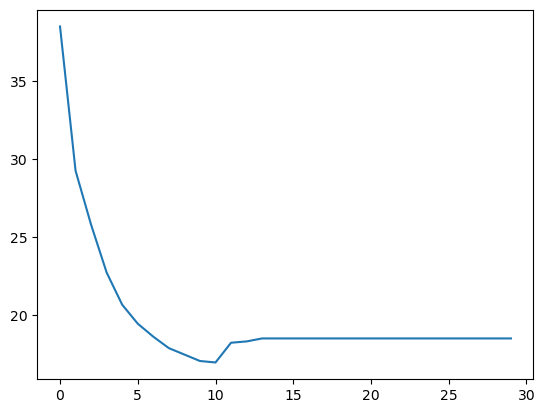

In [368]:
# Calculate SIMILARITY for each phase
dists = []
sims = []
for phase in range(30):
    cluster_idxs = list(phase_results[phase_results['phase']<= phase].grid_idx)
    cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
    dist = within_boundary_distance(cluster_gdf, SIM_CAL_COLS)
    sim = within_boundary_similarity(dist, len(cluster_gdf))
    dists.append(dist)
    sims.append(sim)
plt.plot(dists)

In [337]:
data = sims
# Calculate the first differences
first_diff = [data[i + 1] - data[i] for i in range(len(data) - 1)]

# Calculate the second differences
second_diff = [first_diff[i + 1] - first_diff[i] for i in range(len(first_diff) - 1)]

# Find the index of the smallest second difference
min_index = second_diff.index(min(second_diff))

In [338]:
cluster_idxs = list(phase_results[phase_results['phase']<= min_index].grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [247]:
phase_grid_idxs = phase_results[phase_results['phase']<=10].grid_idx
gdf[gdf['grid_idx'].isin(phase_grid_idxs)].explore(column = 'bd_ilp')

In [175]:
# # 0606 ver1
# prev_grid_idxs = init_cluster
# cluster = init_cluster
# print(f'!! INIT CLUSTER: {init_cluster}')

# TOPK = 3 # number of grids selected for each clustering phase
# phase_results = pd.DataFrame()
# for phase in range(3):
#     # 1) GET TBA INDEXS
#     tba_idxs = []
#     for prev_grid_idx in prev_grid_idxs:
#         tba_idx = find_queen_neighbors(gdf_normalized, prev_grid_idx)
#         tba_idxs = tba_idxs + tba_idx
#     assert len(tba_idxs) > 0
#     tba_idxs = list(set(tba_idxs)- set(cluster))
#     print(f'!! {len(tba_idxs)} TBA indexs in\n{phase+1}th Phase')
#     print(f'!! {cluster} were in cluster in prev phase')
#     # 2) CALCULATE FEATURE DISTANCE
#     idxs = []
#     diffs = []
#     for tba_idx in tba_idxs:
#         copied_cluster = cluster[:]
#         cluster_gdf    = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
#         tba_gdf        = gdf_normalized[gdf_normalized['grid_idx'] == tba_idx]
#         mean_diff      = compare_mean(tba_gdf, cluster_gdf, SIM_CAL_COLS)
#         idxs.append(tba_idx); diffs.append(mean_diff)

#     # 3) GET 3 GRID_IDX which is near to CLUSTER
#     data = {'grid_idx': idxs, 'diffs': diffs}
#     result_df = pd.DataFrame(data)
#     selected_df = result_df.nsmallest(TOPK, 'diffs')
#     selected_df['phase'] = [phase + 1] * len(selected_df)

#     # 4) AND ADD PHASE RESULTS AND NEW CLUSTER
#     phase_results = pd.concat([phase_results, selected_df], axis = 0)
#     prev_grid_idxs =  list(selected_df['grid_idx'])
#     cluster = cluster + prev_grid_idxs
# cluster


!! INIT CLUSTER: [30104, 29932, 29934, 29990, 30303]
!! 2 TBA indexs in
1th Phase
!! [30104, 29932, 29934, 29990, 30303] were in cluster in prev phase
!! 3 TBA indexs in
2th Phase
!! [30104, 29932, 29934, 29990, 30303, 29935, 30374] were in cluster in prev phase
!! 4 TBA indexs in
3th Phase
!! [30104, 29932, 29934, 29990, 30303, 29935, 30374, 30448, 30449, 30447] were in cluster in prev phase


[30104,
 29932,
 29934,
 29990,
 30303,
 29935,
 30374,
 30448,
 30449,
 30447,
 30522,
 30521,
 30523]

In [179]:
phase_results

""


In [174]:
lists = [30104, 29932, 29934, 29990, 30303, 29935, 30374, 30448, 30449, 30447]
gdf[gdf['grid_idx'].isin(lists)].explore()

In [120]:
tba_idxs

[12482, 12483, 12453, 12527, 12502, 12475, 12476]

In [106]:
tba_grid_idxs = []
# append to be added(후보) indexes
for grid_idx in prev_grid_idxs:
    print(grid_idx)
    neighbor_grid_idxs = find_queen_neighbors(gdf_normalized, grid_idx)
    if len(neighbor_grid_idxs) == 0:
        neighbor_grid_idxs = find_neighbors_within_radius(gdf_normalized, grid_idx)
    print(neighbor_grid_idxs)
    tba_grid_idxs.extend(neighbor_grid_idxs)

idxs = []
sims = []

tba_grid_idxs = list(set(tba_grid_idxs))

for tba_grid_idx in tba_grid_idxs:
    copied_cluster = init_cluster.copy()
    copied_cluster.append(tba_grid_idx)
    copied_cluster = list(set(copied_cluster))
    new_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
    dist = within_boundary_distance(new_gdf, SIM_CAL_COLS)
    print(f'Cluster: {copied_cluster}\nDistance: {dist}')

12556
[12481, 12503, 12509, 12528]
12481
[12453, 12482, 12509]
12503
[12475, 12476, 12502, 12527, 12528]
12509
[12481, 12482, 12483]
12528
[12502, 12503, 12527]
Cluster: [12481, 12556, 12528, 12503, 12509]
Distance: 42.74684299497146
Cluster: [12481, 12482, 12556, 12528, 12503, 12509]
Distance: 40.33213027401136
Cluster: [12481, 12483, 12556, 12528, 12503, 12509]
Distance: 41.26093489370195
Cluster: [12481, 12453, 12556, 12528, 12503, 12509]
Distance: 41.062817838516345
Cluster: [12481, 12556, 12527, 12528, 12503, 12509]
Distance: 41.137332662005214
Cluster: [12481, 12556, 12528, 12503, 12509]
Distance: 42.74684299497146
Cluster: [12481, 12556, 12528, 12502, 12503, 12509]
Distance: 40.087031629776654
Cluster: [12481, 12556, 12528, 12503, 12509]
Distance: 42.74684299497146
Cluster: [12481, 12556, 12528, 12503, 12475, 12509]
Distance: 40.26425359738678
Cluster: [12481, 12556, 12528, 12503, 12476, 12509]
Distance: 40.007217773547445
Cluster: [12481, 12556, 12528, 12503, 12509]
Distance: 4

In [148]:
# for phase in range(5):
#     tba_grid_idxs = []
#     for grid_idx in prev_grid_idxs:
#         neighbor_grid_idxs = find_neighbors_within_radius(gdf_normalized, grid_idx)
#         tba_grid_idxs.extend(neighbor_grid_idxs)
    
#     tba_grid_idxs = list(set(tba_grid_idxs))
#     prev_grid_idxs = tba_grid_idxs 
#     assert len(tba_grid_idxs) >= 1
#     cluster.extend(tba_grid_idxs)
#     cluster = list(set(cluster))
#     new_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster)]
#     sim = within_boundary_similarity(new_gdf, SIM_CAL_COLS)
#     print(f'Phase: {phase}\nSimil: {sim}')

Phase: 0
Simil: 12.65965839834619
Phase: 1
Simil: 12.076087441361409
Phase: 2
Simil: 11.589064070395818
Phase: 3
Simil: 11.384102356245497
Phase: 4
Simil: 11.454969669973352


In [149]:
new_gdf.explore()

In [100]:
first_gdf_idx    = list(gdf_normalized.index)[0] # 650(for gbd)
centroid_gdf_idx = gdf_normalized['bd_height'].idxmax()
centroid_w_idx = centroid_gdf_idx - first_gdf_idx
print(f'Centroid Building is {gdf_normalized.loc[centroid_gdf_idx].bdnm}\ngdf_idx is {centroid_gdf_idx}\nw_idx is {centroid_w_idx}')
init_w = Queen.from_dataframe(gdf_normalized)

init_gdf_idxs = list(gdf[gdf['grid_idx'].isin(gbd_init_grid_idx)].index)
init_w_idxs = [x - first_gdf_idx for x in list(init_gdf_idxs)]

cluster = init_w_idxs
prev_w_idxs = cluster

for phase in range(5):
    tba_w_idxs = []
    for w_idx in prev_w_idxs:
        tba_idxs = init_w.neighbors[w_idx]
        if len(tba_idxs) == 0:
            print('zero1!!')
            gdf_idx = w_idx + first_gdf_idx
            gdf_grid_idx = gdf.loc[gdf_idx].grid_idx
            gdf_near_grid_idx = gdf_near_idx_pair[gdf_near_idx_pair['grid_idx'] == gdf_grid_idx].near_grid_idx
            tba_idx = gdf[gdf['grid_idx'] == gdf_near_grid_idx].index - first_gdf_idx
            print(tba_idx)
        else:
            tba_w_idxs.extend(tba_idxs) # tba: to be added
    tba_w_idxs = list(set(tba_w_idxs))
    prev_w_idxs = tba_w_idxs
    assert len(tba_w_idxs) >= 1
    cluster.extend(tba_w_idxs)
    cluster = list(set(cluster))
    cluster_gdf_idxs = [x + first_gdf_idx for x in list(cluster)]
    new_gdf = gdf_normalized.loc[cluster_gdf_idxs]
    print(list(new_gdf.grid_idx.values))
    sim = within_boundary_similarity(new_gdf, SIM_CAL_COLS)
    # print('bdnms', new_gdf.bdnm.values)
    print('round', phase)
    print('sim', sim)

Centroid Building is 삼성전자빌딩
gdf_idx is 2300
w_idx is 598
[35972, 35983, 31258, 31290, 31318, 31319, 31320, 36016, 36024, 36025, 36026, 31360, 31364, 31365, 31366, 31367, 31368, 31369, 31378, 36027, 31405, 31408, 31409, 31410, 31425, 31446, 31466, 36069, 36070, 36071, 36072, 36073, 31476]
round 0
sim 21.75721024110638
[36117, 36118, 36119, 36120, 36121, 36122, 36123, 35972, 35983, 35984, 31258, 31290, 31318, 31319, 31320, 31321, 36016, 36024, 36025, 36026, 31360, 31364, 31365, 31366, 31367, 31368, 31369, 31378, 36027, 36028, 31379, 31405, 31408, 31409, 31410, 31425, 31435, 31445, 31446, 31466, 31330, 31467, 36068, 36069, 36070, 36071, 36072, 36073, 31476, 31335, 36074, 31497, 31503, 31524]
round 1
sim 19.582227690274113
[36116, 36117, 36118, 36119, 36120, 36121, 36122, 36123, 36124, 31258, 31268, 36168, 36169, 36170, 36171, 31283, 31288, 31289, 31290, 31318, 31319, 31320, 31321, 36172, 36173, 36174, 36175, 36176, 31323, 31360, 31364, 31365, 31366, 31367, 31368, 31369, 31378, 31379, 3139

In [99]:
gdf[gdf['grid_idx'].isin([35972, 35983, 31258, 31290, 31318, 31319, 31320, 36016, 36024, 36025, 36026, 31360, 31364, 31365, 31366, 31367, 31368, 31369, 31378, 36027, 31405, 31408, 31409, 31410, 31425, 31446, 31466, 36069, 36070, 36071, 36072, 36073, 31476])].explore()

In [72]:
new_gdf.explore()

In [206]:
within_boundary_similarity(gdf_normalized, SIM_CAL_COLS)

0.950468266890957

In [207]:
foo = gdf_normalized[gdf_normalized['grid_idx'].isin([12556, 12481, 12528, 12503])]
within_boundary_similarity(foo, SIM_CAL_COLS)

0.8028004500225211

#### 2. CBD Index

In [10]:
# for each grids, calculate CBD Index. CBD Index represents two;
# 1. CBDness
# 2. How each grid is similar to other grids in CBD Boundary

# for example, suppose there is very high building with sufficient people, business factor((1)suffices), 
# but if that building is not similar to other buildings around((2)not suffices) CBD Index must show low
# (=like Lionel messi in the amateur league, not in Ligue 1 league)